<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем библиотеки.

In [1]:
import time
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, auc, roc_curve
from sklearn.pipeline import Pipeline
from nltk import pos_tag
import warnings
warnings.filterwarnings('ignore')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Прочитаем данные с файла и сохраним в data.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Согласно документации к данным, в таблице `toxic_comments` имеются следующие столбцы:
* `text` - текст
* `toxic` - размер токсичности
* `Unnamed` - номер текста

Проверим есть ли пропуски.

In [4]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Пропущенных значений не обнаружено.

Посмотрим на распределение значений столбца `toxic`.

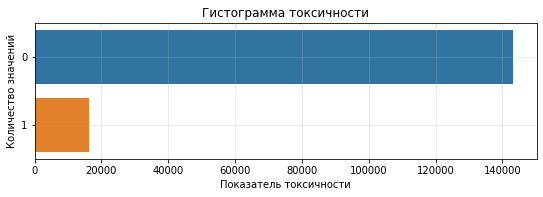

In [5]:
counts = data['toxic'].value_counts()
plt.figure(figsize = (9, 2.5))
ax = sns.barplot(x = counts.values, y = counts.index.astype('str'))
plt.grid(axis='both', alpha=.3)
plt.xlabel('Показатель токсичности')
plt.ylabel('Количество значений')
plt.title('Гистограмма токсичности')
plt.show()

Явно видна несбалансированность классов.

Теперь необходимо подготовить текст для обучения:
- привести текст к нижнему регистру
- удалить все знаки препинания
- удалить стоп-слова
- лемматизировать слова

Напишем функцию подготовки.

In [6]:
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def change(text):
    lemma = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemma.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(text)]
    return ' '.join(text)

In [8]:
data['change'] = data['text'].apply(change)

In [9]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   change      159292 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


,Unnamed: 0,text,toxic,change
0,0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intend wr...
9,9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


**Вывод этапа**:
- Данные загружены и проверены на наличие пропущеных значений (пропусков не обнаружено).
- Построена гистограмма для столбца `toxic`, по которой выявлена несбалансированность.
- Преобразован текст для дальнейшего обучения моделей.

## Обучение

### Подготовка данных

Выделим целевой признак и атрибуты.

In [10]:
target = data['toxic']
features = data['change']

Разделим данные на обучающую и тестовую выборки.

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                target, test_size=0.25, random_state=123)

Выборки готовы, можно приступать к обучению моделей. Для обучения выбраны Логистическая регрессия, Случайный лес и CatBoostClassifier. Также для моделей будем использовать кросс-валидацию.

In [12]:
cv_params = {'scoring': 'f1', 'return_train_score': True, 'cv': 3}

In [13]:
def training(model, params):
    pipeline = Pipeline([('tfidf', TfidfVectorizer(min_df = 1)),('model', model)])
    grid = GridSearchCV(pipeline, n_jobs = -1, **cv_params, param_grid = params ,verbose = False)
    grid.fit(features_train, target_train)
    return grid

### Логистическая регрессия

In [14]:
%%time
grid_l = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})
display(grid_l.best_score_)
display(grid_l.best_params_)

0.7677919968155794

{'model__C': 10.0, 'model__penalty': 'l2'}

CPU times: user 2min 42s, sys: 3min 35s, total: 6min 17s
Wall time: 6min 17s


### Случайный лес

In [15]:
%%time
grid_dtc = training(DecisionTreeClassifier(), {'model__criterion':['gini','entropy'],
                                              'model__max_depth':[2,4,6]})
display(grid_dtc.best_score_)
display(grid_dtc.best_params_)

0.5477857912568593

{'model__criterion': 'entropy', 'model__max_depth': 6}

CPU times: user 2min 2s, sys: 0 ns, total: 2min 2s
Wall time: 2min 3s


### CatBoostClassifier

In [16]:
%%time
grid_cat = training(CatBoostClassifier(logging_level='Silent'), {'model__depth': [4,6],
                 'model__learning_rate' : [0.01,0.03],
                  'model__iterations' : [10, 50]})
display(grid_cat.best_score_)
display(grid_cat.best_params_)

0.5162155598453831

{'model__depth': 6, 'model__iterations': 50, 'model__learning_rate': 0.03}

CPU times: user 26min 44s, sys: 3min 25s, total: 30min 10s
Wall time: 30min 31s


**Вывод этапа**:
- Проведено разделение данных на тестовую и тренировочную выборки.
- Написана функция для работы моделей обучения.
- Обучены модели и получены значения метрики F1: `LinearRegression` - 0.77, `DecisionTreeClassifier` - 0.55 и `CatBoostRegressor` - 0.52.

Лучшей моделью является LinearRegression, так как он показывает наилучший результат метрики F1.

## Тестирование

Проведем тестирование лучшей модели.

In [17]:
%%time
predict_l = grid_l.predict(features_test)
f1_l = f1_score(target_test, predict_l)
print("F1 LinearRegression:", f1_l)

F1 LinearRegression: 0.7858328721638073
CPU times: user 1.07 s, sys: 2.08 ms, total: 1.07 s
Wall time: 1.08 s


**Вывод этапа**:
Проведено тестирование лучшей модели, получено значение F1 = 0.79

## Выводы

**Вывод этапа**:

Итак, нам предоставлены данные интернет-магазина «Викишоп», которому нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

На этапе подготовки данные были загружены и проверены на наличие пропущеных значений (пропусков не обнаружено). Построена гистограмма для столбца `toxic`, по которой выявлена несбалансированность целевого признака. А также преобразован текст для дальнейшего обучения моделей.

Для обучения проведено разделение данных на тестовую и тренировочную выборки, написана функция для работы моделей обучения. Выбрано 3 модели: `LinearRegression`, `DecisionTreeClassifier`, `CatBoostRegressor`.

Дальнейшее обучеие дало следующие значения метрики F1: `LinearRegression` - 0.77, `DecisionTreeClassifier` - 0.55 и `CatBoostRegressor` - 0.52. Лучшей моделью является LinearRegression, так как она показывает наилучший результат метрики F1.

И последним этапом проведено тестирование линейной регрессии на тестовой выборке, где получен результат F1 = 0.79.

